#Imports

In [1]:
import io
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score
import datetime as dt

# Laden der Daten 
Die Daten werden aus einem CSV File in einen Pandas Dataframe geladen.
Besonderes Augenmerk muss hier auf den Zeitstempel gelegt werden:
Mit dem Formatstring **'%d.%m.%Y'** wird die integrität der Datumsspalte sichergestellt. Da wir fuer die Baseline regression auch den original Datensatz benoetigen haben wir uns entschieden das Laden der Daten als Funktion zu formulieren.
Da die beiden Datensaetze eine unterschiedliche Datumsformatierung haben muessen wir einen Boolean uebergeben. Dieser gibt auskunft darueber ob es sich um den Originalen oder den Aufbreiteten Datensatz handelt.

In [2]:
Task1dfURL="https://raw.githubusercontent.com/leanderpeter/advanced-data-science-ss21-gruppe1/master/dataset_f_exploration.csv"
OriginaldfURL="https://raw.githubusercontent.com/kevin-eberhardt/advanced-data-science-ss21-gruppe1/main/data/BikeRentalDaily_train_valid.csv"
OriginalKaggleURL="https://raw.githubusercontent.com/leanderpeter/advanced-data-science-ss21-gruppe1/master/original_dataset.csv"
def load_data(url, ori):
  requested_file = requests.get(url).content
  decoded_file = io.StringIO(requested_file.decode('utf-8'))
  if ori == 'meth_ori':
    data = pd.read_csv(decoded_file, sep = ";")
    data["dteday"]= pd.to_datetime(data["dteday"], format='%d.%m.%Y')
  elif ori == 'exploration_clean':
    data = pd.read_csv(decoded_file, sep = ";")
    data["dteday"]= pd.to_datetime(data["dteday"], format='%Y.%m.%d')
  elif ori == 'kaggle_ori':
    data = pd.read_csv(decoded_file, sep = ",")
    data["dteday"]= pd.to_datetime(data["dteday"], format='%Y-%m-%d')
  return data

original_df = load_data(OriginaldfURL, 'meth_ori')
cleaned_df = load_data(Task1dfURL, 'exploration_clean')
original_kaggle_dataset = load_data(OriginalKaggleURL, 'kaggle_ori')

# Baseline regression

## Multiple feature regression

Um einen vergleichswert zu erhalten sowie das verstaendnis fuer die Daten zu erhoehen fuehren wir eine Baseline Regression durch. Hierbei bereiten wir den Datensatz minimal auf und geben ihn mit der Zielvariable in eine lineare Regression. Die minimale aufbereitung uebernimmt die variablen '**temp**', '**leaflets**', '**windspeed**','**season**', '**atemp**', '**hum**'

In [3]:
#  use all features for the baseline regression
ori_reg_df = original_df.dropna()
x = ori_reg_df[['temp', 'leaflets', 'windspeed','season', 'atemp', 'hum',"price reduction","yr","mnth","holiday","weekday","workingday","weathersit","price reduction"]]
y = ori_reg_df['cnt']

# split x and y into test and train
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.30 ,random_state = 2)

## baseline multiple features linear regression

In [4]:
clf_lr = LinearRegression()      
lr_baseline_model = clf_lr.fit(x_train,y_train)

def generate_accuracy_and_heatmap(model, x, y):
    #cm = confusion_matrix(y,model.predict(x))
    #sns.heatmap(cm,annot=True,fmt="d")
    # Make predictions using the testing set
    pred = model.predict(x)

    # The coefficients
    # print('Coefficients: \n', model.coef_)
    # The mean squared error
    # print('Mean squared error: %.2f' % mean_squared_error(y, pred))
    # The coefficient of determination: 1 is perfect prediction
    # print('Coefficient of determination: %.2f' % r2_score(y, pred))
    return r2_score(y, pred)

generate_accuracy_and_heatmap(lr_baseline_model, x_test, y_test)

0.3225454547596318

Bei der Baseline Regression kommen wir auf einen **R² Wert von 0.322**. Dieser ist nicht zufriedenstellend und bietet moeglichkeiten der verbesserung. In der Grafik sind die, schon in der data exploration aufgefallenen, outlier zu sehen.

# Preprocessing

## Data Preparing

Da unsere Test Daten aus einem unberuehrten Datensatz stammen muessen wir die Data Preparation Prozesse fuer weekday sowie season und date_offset auch in die Preprocessing pipeline mit einbringen.

### Weekday Clean

In [5]:
def weekday_clean(dataframe):
  dataframe['weekday_clean'] = dataframe['dteday'].dt.dayofweek
  return dataframe

### Season Clean

In [6]:
def season_date_offset(dataframe):
  dataframe['date_offset'] = (dataframe.dteday.dt.month*100 + dataframe.dteday.dt.day - 320)%1300
  dataframe['season_clean'] = pd.cut(dataframe['date_offset'], [-1, 300, 602, 900, 1300], labels=[2, 3, 4, 1])
  return dataframe

## Drop unnecessary

Wir wissen bereits aus der Data Exploration das die Summe aus den Werten **casual** und **registered** unsere Zielvariable gebildet wird. Somit werden wir diese Spalten entfernen.


---


Gleichzeitig wurden bereits in der Data Exploration bereits die Spalten Season durch season_clean ersetzt sowie weekday durch weekday_clean. Somit entfernen wir auch hier die Spalten **season** und **weekday**.


---

Auch hat werden wir fuer das weitere verfahren die Gefuelhte Temperatur verwenden **atemp**.


---

Auch hat sich gezeigt das die Anzahl der leaflets ueber beide Jahre gleich verteilt ist. Diese kann somit auch entfernt werden.

In [7]:
def remove_unnecessary(dataframe, columns):
  for cols in columns: 
    del dataframe[cols]
  return dataframe

#cleaned_df = remove_unnecessary(cleaned_df,['casual', 'registered', 'season', 'weekday', 'hum', 'temp', 'windspeed', 'instant', 'leaflets'])
#cleaned_df.head(10)

##Missing Values

Unsere Strategie besteht darin, aus der Spalte mit den fehlenden Werten neue Spalten zu erstellen und deren Auswirkung auf die Zielspalte zu überprüfen. Die schlechteren Spalten werden eliminiert und nur die nützlichen Spalten für die Schleife des maschinellen Lernens behalten.

Durch die Data Exploration in Task 1 wissen wir bereits das wir in den Spalten **season** und **hum** fehlende Werte haben. Um das zu ueberpruefen lassen wir uns erneut die fehlenden Werte anzeigen. 

---

Es ist zu anzumerken das wir ab diesem Abschnitt mit dem vorbereiteten Datensatz von der Data Exploration Arbeiten

In [8]:
cleaned_df.isnull().sum()

Unnamed: 0          0
instant             0
dteday              0
season             62
yr                  0
mnth                0
holiday             0
weekday             0
workingday          0
weathersit          0
temp                0
atemp               0
hum                34
windspeed           0
leaflets            0
price reduction     0
casual              0
registered          0
cnt                 0
date_offset         0
season_clean        0
weekday_clean       0
dtype: int64

Zu erkennen ist das es sich um 62 fehlende season Werte sowie 34 fehlende hum Werte handelt. Hierbei ist besonders zu beachten das es sich bei season um ein Kategeorisches Featrue und bei hum um ein Numerisches Feature handelt.

---

Durch die Vorarbeit der Data Exploration haben wir bereits eine Spalte mit den korrekten Season Werten - **season_clean**.

Folgende Methoden der imputaion wenden wir an:


1.   **Mean imputation**
2.   **Median imputation**
3.   **Constant imputation**
4.   **Avergae imputation with most frequent strategy**
5.   Deterministic Regression imputation
6.   Knn imputation

Wir definieren fuer die ersten 4 strategien eine Funktion welche 3 parameter erwartet. Diese sind dataframe fuer den datensatz, column fuer die zu behandelnde Spalte sowie strategy welche die strategie bestimmt (mean, median, constant, most_frequent). Constant sollte hierbei nicht verwendet werden, da es fuer missing values eine 0 uebergibt

### Simple Imputer


In [9]:
from sklearn.impute import SimpleImputer

def unvariate_imputation(dataframe, column, strategy):
  imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
  clean_name = f"{column}_{strategy}_clean"
  dataframe[clean_name] = dataframe[column]
  dataframe[clean_name] = imp.fit_transform(dataframe[[clean_name]].to_numpy())
  return dataframe
  
# beispiel funktionsaufruf
# cleaned_df = unvariate_imputation(cleaned_df, 'hum', 'mean')




1.   Mean imputation
2.   Median imputation
3.   Constant imputation
4.   Avergae imputation with most frequent strategy
5.   **Deterministic Regression imputation**
6.   Knn imputation

Fuer die Determnistische Regression Imputation definieren wir eine Funktion welche 4 Parameter entgegennimmt. dataframe, welche den Datensatz darstellt, column fuer die zu behandelnde Spalte, refrence_column welche die X variable der Regression darstellt sowie iteration welche die Anzahl an Iterationen darstellt.

### Regression Imputer


In [10]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def regression_imputation(dataframe, column, refrence_column, iteration):
  clean_name = f"{column}_regression_with_{iteration}_clean"
  dataframe[clean_name] = dataframe[column]
  imp = IterativeImputer(max_iter=iteration, sample_posterior=False)
  dataframe[clean_name] = np.round(imp.fit_transform(dataframe[[clean_name, refrence_column]].to_numpy()),3)
  return dataframe

# beispiel funktionsaufruf
#cleaned_df = regression_imputation(cleaned_df, 'hum', 'temp', 100)
#cleaned_df.head(100)

1.   Mean imputation
2.   Median imputation
3.   Constant imputation
4.   Avergae imputation with most frequent strategy
5.   Deterministic Regression imputation
6.   **Knn imputation**

Fuer die Knn Imputation definieren wir eine Funktion welche 4 Parameter entgegennimmt. Dataframe, welche den Datensatz darstellt, column fuer die zu behandelnde Spalte, refrence_column welche die X variable der Knn darstellt sowie n welche die Anzahl an Nachbarn darstellt.

### Knn Imputer

In [11]:
from sklearn.impute import KNNImputer

def knn_imputation(dataframe, column, refrence_column, n):
  clean_name = f"{column}_knn_clean"
  dataframe[clean_name] = dataframe[column]
  imputer = KNNImputer(n_neighbors=n, weights="uniform")
  dataframe[clean_name] = imputer.fit_transform(dataframe[[clean_name, refrence_column]].to_numpy())
  return dataframe

# beispiel funktionsaufruf
# cleaned_df = knn_imputation(cleaned_df, 'hum', 'temp', 2)
# cleaned_df.head(50)

1.   Mean imputation
2.   Median imputation
3.   Constant imputation
4.   Avergae imputation with most frequent strategy
5.   Deterministic Regression imputation
6.   Knn imputation
7.   **Random Forest Regressor**

Fuer die Knn Imputation definieren wir eine Funktion welche 4 Parameter entgegennimmt. Dataframe, welche den Datensatz darstellt, column fuer die zu behandelnde Spalte, refrence_column welche die X variable der Knn darstellt sowie n welche die Anzahl an Nachbarn darstellt.

## Random Forest Imputer

In [12]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_imputation(data, column, pred_columns):
  clean_name = f"{column}_random_forest_clean"
  data[clean_name] = data[column]
  if True in data.isnull()[column].unique():
    print('Outlier Found -- Starting imputation')
    hum_nans = data[data[clean_name].isnull()]
    hum_not_nan = data[data[clean_name].notnull()]
    hum_random_forest = RandomForestRegressor()
    hum_random_forest.fit(hum_not_nan[pred_columns], hum_not_nan[clean_name])
    hum_pred_values = hum_random_forest.predict(X= hum_nans[pred_columns])
    hum_nans[clean_name] = hum_pred_values
    data = hum_not_nan.append(hum_nans)
    data.reset_index(inplace=True)
    data.drop('index',inplace=True,axis=1)
    return data
  else:
    print('no outliers found')
    return data
  

#cleaned_df = random_forest_imputation(cleaned_df, 'hum', ["season_clean","weathersit","windspeed","mnth","temp","yr","atemp"])
#cleaned_df.head(50)

## Remove Wind Outliers

In dieser Funktion werden alle Windspeed Werte entfernt die einen Wert kleiner oder gleich 0 haben.

In [13]:
def remove_wind_outliers(dataset, column):
  dataset[column] = dataset[column].apply(lambda x : x if x >= 0 else np.nan)
  return dataset

# cleaned_df = remove_wind_outliers(cleaned_df, 'windspeed')
# cleaned_df.head(10)

## Transformationen

Um eine einfache Imputation zu verwenden, müssen wir auch die kategorischen Werte in ein numerisches Format konvertieren. Die Lösung ist die Verwendung von Encodern und glücklicherweise bietet SKLearn eine Vielzahl von Encodern. Eine detaillierte Liste der Encoder finden Sie in der sklearn.preprocessing API, aber für unseren Fall verwenden wir den LabelEncoder sowie den OneHotEncoder. Nach den Encodern werden wir auch die Normalisierer behandeln.

### OneHotEncoder

Der OneHotEncoder erweitert die Anzahl der Features in einem Datensatz, für jedes Label in der Spalte //und wird bei ungeordneten (ordinalen) Daten verwendet//. Nach der Erweiterung wird das Label unter der Spalte als 1 und für den Rest als 0 angezeigt.
Wir definieren eine Funktion welche 2 Parameter entgegennimmt, dataframe fuer den Datensatz, sowie column fuer die Spalte welche bearbeitet werden soll. Die Funktion loescht nun die Spalte und fuegt am Dataframe die hot encodeten spalten mit Name {column_hot-encoded-label} an.

In [14]:
from sklearn.preprocessing import LabelBinarizer

def one_hot_encoder(dataframe, column):
  lb = LabelBinarizer()
  dataframe = dataframe.join(pd.DataFrame(lb.fit_transform(dataframe[column]),columns=lb.classes_, index=dataframe.index))
  uniques = dataframe[column].unique()
  col_names = {}
  for i in uniques:
    col_names[i] = f"{column}_{i}"
  dataframe = dataframe.rename(columns=col_names)
  return dataframe

# cleaned_df = one_hot_encoder(cleaned_df, 'holiday')
# cleaned_df.head(50)

## Outliers

This function takes care of outliers. It simply takes away everything above the 75th quantile and below the 25th quantile in a specified column

In [15]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

## Normalization
numerical_featuress = ["temp","atemp","hum","windspeed","leaflets"]

### MinMaxScaler

//MinMax-Normierung wird verwendet, um alle Werte in den Bereich von 0 bis 1 zu bringen//

In [16]:
from sklearn import preprocessing

numerical_features = ["temp","atemp","hum","windspeed","leaflets"]

def min_max_scaler(dataframe, columns):
  min_max_scaler = preprocessing.MinMaxScaler()
  dataframe[columns] = min_max_scaler.fit_transform(dataframe[columns])
  return dataframe

# cleaned_df = min_max_scaler(cleaned_df, numerical_features)
# cleaned_df.head(50)

### Standard Scaler

//StandardScaler transformiert Daten so, dass ihre Verteilung einen Mittelwert von 0 und eine Standardabweichung von 1 hat.//

In [17]:
from sklearn import preprocessing

def standard_scaler(dataframe, columns):
  standard_scaler = preprocessing.StandardScaler()
  dataframe[columns] = standard_scaler.fit_transform(dataframe[columns])
  return dataframe

#cleaned_df = standard_scaler(cleaned_df, numerical_features)
#cleaned_df.head(50)

###Robust Scaler

//Wenn Daten viele Ausreißer enthalten, ist die Skalierung mit dem Mittelwert und der Standardabweichung oft nicht gut. In diesen Fällen entfernt RobustScaler den Median und skaliert die Daten entsprechend dem Quantilbereich.//

In [18]:
from sklearn import preprocessing

def robust_scaler(dataframe, columns):
  robust_scaler = preprocessing.RobustScaler()
  dataframe[columns] = robust_scaler.fit_transform(dataframe[columns])
  dataframe[columns] = robust_scaler.transform(dataframe[columns])
  return dataframe

# cleaned_df = robust_scaler(cleaned_df, numerical_features)
# cleaned_df.head(50)

###QuantileTransformer

//QuantileTransformer wendet eine nichtlineare Transformation an, so dass die Wahrscheinlichkeitsdichtefunktion jedes Merkmals auf eine Gleichverteilung abgebildet wird. In diesem Fall werden alle Daten in den Bereich von 0 bis 1 abgebildet, auch die Ausreißer, die nicht mehr von den Normalwerten unterschieden werden können.

Wie RobustScaler ist QuantileTransformer robust gegenüber Ausreißern in dem Sinne, dass das Hinzufügen oder Entfernen von Ausreißern in der Trainingsmenge annähernd die gleiche Transformation auf den herausgehaltenen Daten ergibt. Aber im Gegensatz zu RobustScaler kollabiert QuantileTransformer auch automatisch jeden Ausreißer, indem er ihn auf die definierten Bereichsgrenzen (0 und 1) setzt.//

Func takes in 3 args, column needs to be list

In [19]:
from sklearn.preprocessing import QuantileTransformer

def quantile_transformer(dataframe, column, quantiles):
  # why the fuck did i added all transformed values to the dataframe?!
  # just replce them
  trans = QuantileTransformer(n_quantiles=quantiles, output_distribution='normal')
  data = trans.fit_transform(dataframe[column])
  # convert the array back to a dataframe
  dataframe[column] = data
  return dataframe

# cleaned_df = quantile_transformer(cleaned_df, ['temp'], 10)
# cleaned_df.head(10)

## Feature Selection

Das Ziel der rec_feature_eliminator funktion besteht darin, Features auszuwählen, indem rekursiv immer kleinere Sets von Features berücksichtigt werden. Zuerst wird der estimator auf dem anfänglichen Set von Features trainiert und die Wichtigkeit jedes Features wird entweder durch ein bestimmtes Attribut oder durch einen Callable ermittelt. Dann werden die am wenigsten wichtigen Merkmale aus dem aktuellen Satz von Merkmalen entfernt. Diese Prozedur wird rekursiv mit dem beschnittenen Satz wiederholt, bis die gewünschte Anzahl der auszuwählenden Merkmale schließlich erreicht ist.

###Rekursive feature elimination

In [20]:
from sklearn.feature_selection import RFE

def rec_feature_elimination(dataframe, split, target, return_training_data, columns_consider):
  X = dataframe[columns_consider]
  Y = dataframe['cnt']
  x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=split, 
                                                    random_state=8)
  reg = linear_model.LinearRegression()
  reg.fit(x_train, y_train)
  rfe = RFE(estimator=reg, step=1)
  rfe = rfe.fit(x_train, y_train)
  selected_rfe_features = pd.DataFrame({'Feature':list(x_train.columns),'Ranking':rfe.ranking_})

  print('Optimal number of features :', rfe.n_features_)
  print('Best features :', x_train.columns[rfe.support_])

  if return_training_data:
    x_train_rfe = rfe.transform(x_train)
    x_test_rfe = rfe.transform(x_test)
    return x_train_rfe, x_test_rfe, y_train, y_test
  else:
    return selected_rfe_features

# ranking = rec_feature_elimination(cleaned_df, 0.3, 'cnt', False)
# ranking.sort_values(by='Ranking')

Die Funktion rec_feature_elimination_cv nimmt 4 Parameter entgegen. dataframe, der datensatz, cross die Anzahl an cross-folds, columns_consider die spalten welche fuer das training beruecksichtigt werden sollen sowie split welches den faktor der aufteilung zwischen test und trainingsdatensatz angibt. Die funktion uebernimmt das Feature-Ranking mit rekursiver Feature-Elimination und kreuzvalidierter Auswahl der besten Anzahl von Features.

### Rekursive feature elimination mit cross validation

In [21]:
from sklearn.feature_selection import RFECV

def rec_feature_elimination_cv(dataframe, cross, columns_consider, split):
  X = dataframe[columns_consider]
  Y = dataframe['cnt']
  x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=split, 
                                                    random_state=8)
  reg = linear_model.LinearRegression()
  reg.fit(x_train, y_train)

  rfecv = RFECV(estimator=reg, step=1, cv=cross)
  rfecv = rfecv.fit(x_train, y_train)
  print('Optimal number of features :', rfecv.n_features_)
  print('Best features :', x_train.columns[rfecv.support_])
  '''
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score of number of selected features")
  plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
  plt.show()
  '''
  x_train_rfecv = rfecv.transform(x_train)
  x_test_rfecv = rfecv.transform(x_test)

  return x_train_rfecv, x_test_rfecv, y_train, y_test



### Univariate feature selection

In [22]:
from sklearn.feature_selection import SelectKBest, chi2

def univariate_feature_selection(dataframe, columns_consider, split):
  X = dataframe[columns_consider]
  Y = dataframe['cnt']
  x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=split, 
                                                    random_state=8)
  select_feature = SelectKBest(chi2, k=5).fit(x_train, y_train)
  #selected_features_df = pd.DataFrame({'Feature':list(x_train.columns),'Scores':select_feature.scores_})
  #selected_features_df.sort_values(by='Scores', ascending=False)
  x_train_chi = select_feature.transform(x_train)
  x_test_chi = select_feature.transform(x_test)
  return x_train_chi, x_test_chi, y_train, y_test


# x_train_chi, x_test_chi, y_train, y_test = univariate_feature_selection(cleaned_df, cols_to_consider, 0.3)

Hier klopfen wir nur das Preprocessing in einer test funktion zusammen und schauen wie sich unsere Werte bisher verbessern (oder verschlechtern).


---


Hierbei haben wir die verschiedenen Methode, recursive feature elimination und recursive feature elimination with cross validation manuelle feature selection, gegeneinander antreten lassen. Hierbei war zu erkennen das beide Methoden das Ergebnis massgeblich verschlechtert haben.

# Testing Playground

Outlier Found -- Starting imputation
Outlier Found -- Starting imputation


/home/l/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/l/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Optimal number of features : 21
Best features : Index(['yr', 'holiday', 'weathersit', 'atemp', 'season_clean',
       'hum_mean_clean', 'hum_median_clean', 'hum_most_frequent_clean',
       'hum_regression_with_10_clean', 'hum_knn_clean',
       'hum_random_forest_clean', 'weathersit_2', 'weathersit_3', 'mnth_1',
       'mnth_2', 'mnth_7', 'mnth_9', 'mnth_11', 'mnth_12', 'season_clean_2',
       'weekday_clean_6'],
      dtype='object')
(417, 21)
REC elimination R^2:  0.8070159518791507
Optimal number of features : 42
Best features : Index(['yr', 'mnth', 'holiday', 'workingday', 'weathersit', 'atemp',
       'windspeed_random_forest_clean', 'price reduction', 'season_clean',
       'weekday_clean', 'hum_mean_clean', 'hum_median_clean',
       'hum_most_frequent_clean', 'hum_regression_with_10_clean',
       'hum_knn_clean', 'hum_random_forest_clean', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_6', 'mnth_7', 'mnth

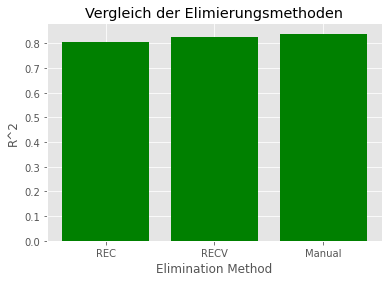

In [23]:
# sample/shuffle dataframe
# cleaned_df = cleaned_df.sample(frac=1).reset_index(drop=True)

def preprocess(cleaned_df):
  #imputation
  cleaned_df = unvariate_imputation(cleaned_df, 'hum', 'mean')
  cleaned_df = unvariate_imputation(cleaned_df, 'hum', 'median')
  cleaned_df = unvariate_imputation(cleaned_df, 'hum', 'most_frequent')
  # regression imputer
  cleaned_df = regression_imputation(cleaned_df, 'hum', 'temp', 10)
  cleaned_df = knn_imputation(cleaned_df, 'hum', 'temp', 2)
  cleaned_df = random_forest_imputation(cleaned_df, 'hum', ["season_clean","weathersit","windspeed","mnth","temp","yr","atemp"])
  # wind outlier
  cleaned_df = remove_wind_outliers(cleaned_df, 'windspeed')
  #windspeed imputation 
  cleaned_df = random_forest_imputation(cleaned_df, 'windspeed', ["season_clean","weathersit","mnth","temp","yr","atemp"])
  # encoding
  cleaned_df = one_hot_encoder(cleaned_df, 'weathersit')
  cleaned_df = one_hot_encoder(cleaned_df, 'mnth')
  cleaned_df = one_hot_encoder(cleaned_df, 'season_clean')
  cleaned_df = one_hot_encoder(cleaned_df, 'weekday_clean')

  # die Spalten price reduction, workingday und holiday sind bereits
  # binaere daten. Somit ist ein one hot encoding nicht notwendig
      # cleaned_df = one_hot_encoder(cleaned_df, 'price reduction')
      # cleaned_df = one_hot_encoder(cleaned_df, 'workingday')
      # cleaned_df = one_hot_encoder(cleaned_df, 'holiday')

  # drop all unnecessary values
  cleaned_df = remove_unnecessary(cleaned_df,['casual', 'registered', 'season', 'weekday', 'hum', 'temp', 'windspeed', 'instant', 'leaflets'])

  #normalization
  numerical_features = ["atemp", 'windspeed_random_forest_clean', 'hum_mean_clean', 'hum_median_clean', 'hum_most_frequent_clean',
       'hum_regression_with_10_clean', 'hum_knn_clean',
       'hum_random_forest_clean']
  # cleaned_df = min_max_scaler(cleaned_df, numerical_features)
  # cleaned_df = standard_scaler(cleaned_df, numerical_features)
  cleaned_df = robust_scaler(cleaned_df, numerical_features)

  for i in range(len(numerical_features)):
    pass
    # cleaned_df = quantile_transformer(cleaned_df, [numerical_features[i]], 15)
  return cleaned_df

cleaned_df = preprocess(cleaned_df)

cols_to_consider = ['yr', 'mnth', 'holiday','workingday', 'weathersit', 'atemp',
       'windspeed_random_forest_clean', 'price reduction', 'date_offset', 'season_clean', 
       'weekday_clean', 'hum_mean_clean',
       'hum_median_clean', 'hum_most_frequent_clean',
       'hum_regression_with_10_clean', 'hum_knn_clean',
       'hum_random_forest_clean', 'weathersit_1', 'weathersit_2',
       'weathersit_3', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'season_clean_1', 'season_clean_2', 'season_clean_3', 'season_clean_4',
       'weekday_clean_0', 'weekday_clean_1', 'weekday_clean_2',
       'weekday_clean_3', 'weekday_clean_4', 'weekday_clean_5',
       'weekday_clean_6'] 



cols_to_consider_manual = ['yr', 'holiday', 'workingday', 'atemp',
       'windspeed_random_forest_clean', 'price reduction', 'date_offset',  
       'weekday_clean','hum_random_forest_clean', 'weathersit_1', 'weathersit_2',
       'weathersit_3', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'season_clean_1', 'season_clean_2', 'season_clean_3', 'season_clean_4'
       ]


def testpipeline_rec(cleaned_df, cols_to_consider, clf_lr):
  x_train_rfe, x_test_rfe, y_train_rfe, y_test_rfe = rec_feature_elimination(cleaned_df, 0.3, 'cnt', True, cols_to_consider)
  print(x_train_rfe.shape)
  new_rfe_model = clf_lr.fit(x_train_rfe, y_train_rfe)
  return generate_accuracy_and_heatmap(new_rfe_model, x_test_rfe, y_test_rfe)

# ranking = rec_feature_elimination(cleaned_df, 0.3, 'cnt', False, cols_to_consider)
# ranking.sort_values(by='Ranking')

def testpipeline2_recv(cleaned_df, cols_to_consider, clf_lr):
  x_train_rfe, x_test_rfe, y_train_rfe, y_test_rfe = rec_feature_elimination_cv(cleaned_df, 5, cols_to_consider, 0.3)
  print(x_train_rfe.shape)
  new_rfe_model = clf_lr.fit(x_train_rfe, y_train_rfe)
  return generate_accuracy_and_heatmap(new_rfe_model, x_test_rfe, y_test_rfe)

def testpipeline3_chi_square(cleaned_df, cols_to_consider, clf_lr):
  x_train_chi, x_test_chi, y_train, y_test = univariate_feature_selection(cleaned_df, cols_to_consider, 0.3)
  print(x_train_rfe.shape)
  new_rfe_model = clf_lr.fit(x_train_rfe, y_train_rfe)
  return generate_accuracy_and_heatmap(new_rfe_model, x_test_rfe, y_test_rfe)

def test_without_method(cleaned_df, cols_to_consider):
  X = cleaned_df[cols_to_consider]
  y = cleaned_df['cnt']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

  reg = LinearRegression().fit(X_train, y_train)
  score_without = reg.score(X_test, y_test)

  return score_without


print("REC elimination R^2: ",testpipeline_rec(cleaned_df, cols_to_consider, clf_lr))
print("RECV elimination R^2: ",testpipeline2_recv(cleaned_df, cols_to_consider, clf_lr))
# print("Chi2 elimination R^2: ",testpipeline3_chi_square(cleaned_df, cols_to_consider, clf_lr))
print("Manual elimination R^2: ",test_without_method(cleaned_df, cols_to_consider_manual))

plt.style.use('ggplot')

x = ['REC', 'RECV', 'Manual']
vals = [testpipeline_rec(cleaned_df, cols_to_consider, clf_lr), testpipeline2_recv(cleaned_df, cols_to_consider, clf_lr),test_without_method(cleaned_df, cols_to_consider_manual)]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, vals, color='green')
plt.xlabel("Elimination Method")
plt.ylabel("R^2")
plt.title("Vergleich der Elimierungsmethoden")

plt.xticks(x_pos, x)

plt.show()

Aus den oberen Daten zeigt sich das unsere Manuelle feature selection keine Signifikant schlechteren Ergebnisse erzielt das **RFE** und **RFEV**

# Preprocessing Pipeline

In dieser Pipeline werden alle Daten verarbeitet. Die Pipeline ist darauf ausgelegt das wir auch "fremde" Daten vorverarbeiten koennen um mit diesen unser Model zu testen.


---

**Hier sollte nochmal was zur Strategie stehen**

Random Forest Imputation weil Daten nicht normalisiert sein muessen.

In [24]:
cleaned_df.head(10)

,Unnamed: 0,dteday,yr,mnth,holiday,workingday,weathersit,atemp,price reduction,cnt,...,season_clean_2,season_clean_3,season_clean_4,weekday_clean_0,weekday_clean_1,weekday_clean_2,weekday_clean_3,weekday_clean_4,weekday_clean_5,weekday_clean_6
0,0,2011-06-03,0,6,0,1,1,-0.426699,0,5312,...,1,0,0,0,0,0,0,1,0,0
1,1,2012-11-15,1,11,0,1,2,-4.104375,0,5445,...,0,0,1,0,0,0,1,0,0,0
2,2,2012-01-03,1,1,0,1,1,-6.879942,0,2236,...,0,0,0,0,1,0,0,0,0,0
3,3,2012-04-16,1,4,1,0,1,-0.037537,0,6370,...,1,0,0,1,0,0,0,0,0,0
4,4,2012-03-17,1,3,0,0,2,-1.576137,1,7836,...,0,0,0,0,0,0,0,0,1,0
5,5,2011-09-14,0,9,0,1,1,0.130145,0,4785,...,0,1,0,0,0,1,0,0,0,0
6,7,2012-10-04,1,10,0,1,2,-0.134856,0,7328,...,0,0,1,0,0,0,1,0,0,0
7,8,2011-10-01,0,10,0,0,2,-2.866945,0,2429,...,0,0,1,0,0,0,0,0,1,0
8,9,2011-05-09,0,5,0,1,1,-1.293283,0,4362,...,1,0,0,1,0,0,0,0,0,0
9,10,2011-06-24,0,6,0,1,1,0.545786,0,4991,...,0,1,0,0,0,0,0,1,0,0


In [25]:
def preprocess_pipeline(dataframe, cols_to_consider):
  # weekday -> weekday_clean
  dataframe = weekday_clean(dataframe)
  # season -> season_clean + date_offset
  dataframe = season_date_offset(dataframe)
  # remove outliers (cnt)
  dataframe = remove_outlier(dataframe, 'cnt')
  # remove outliers (wind)
  dataframe = remove_wind_outliers(dataframe, 'windspeed')
  # random forest imputation (windspeed)
  dataframe = random_forest_imputation(dataframe, 'windspeed', ["season_clean","weathersit","mnth","atemp","yr"])
  # random forest imputation (hum)
  dataframe = random_forest_imputation(dataframe, 'hum', ["season_clean","weathersit","windspeed_random_forest_clean","mnth","atemp","yr"])
  # one hot encoding (weathersit)
  dataframe = one_hot_encoder(dataframe, 'weathersit')  
  # one hot encoding (mnth)
  dataframe = one_hot_encoder(dataframe, 'mnth')
  # one hot encoding (season_clean)
  dataframe = one_hot_encoder(dataframe, 'season_clean')
  # normalize min max scaler (all numeric values ?)
  numerical_features = ["atemp", 'windspeed_random_forest_clean', 'hum_random_forest_clean', 'date_offset', 'weekday_clean']
  dataframe = min_max_scaler(dataframe, numerical_features)
  # Split in X and y for training or testing

  X = dataframe[cols_to_consider]
  y = dataframe['cnt']
  return X, y

### Run the Pipeline

In [26]:
cols_to_consider_manual = ['yr', 'holiday', 'workingday', 'atemp',
       'windspeed_random_forest_clean', 'date_offset',  
       'weekday_clean','hum_random_forest_clean', 'weathersit_1', 'weathersit_2',
       'weathersit_3', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'season_clean_1', 'season_clean_2', 'season_clean_3', 'season_clean_4']

X, y = preprocess_pipeline(original_df, cols_to_consider_manual)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)



#X_TEST, y_TEST = preprocess_pipeline(original_kaggle_dataset, cols_to_consider_manual)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0., random_state=8)
#reg = LinearRegression().fit(X_train, y_train)
#score_without = reg.score(X_TEST, y_TEST)
#print(score_without)

/home/l/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/l/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/l/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

Outlier Found -- Starting imputation
Outlier Found -- Starting imputation


/home/l/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Grid Search Polynomial Regression

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut, KFold

pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression()),
])

pows = range(1,5)

search = GridSearchCV(
    estimator=pipe,
    param_grid={'poly__degree': list(pows)},
    scoring='neg_mean_squared_error',
    cv=LeaveOneOut(),
)

search.fit(X_train, y_train)

y_pred = search.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(r2)
print(search.cv_results_)

0.8348625179099252
{'mean_fit_time': array([0.00331446, 0.03116152, 0.16055297, 0.97716313]), 'std_fit_time': array([0.00028419, 0.00993392, 0.0421679 , 0.10996532]), 'mean_score_time': array([0.00132245, 0.0019787 , 0.00253591, 0.00338927]), 'std_score_time': array([0.00016178, 0.00050561, 0.00081562, 0.00170396]), 'param_poly__degree': masked_array(data=[1, 2, 3, 4],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'poly__degree': 1}, {'poly__degree': 2}, {'poly__degree': 3}, {'poly__degree': 4}], 'split0_test_score': array([ -422500.        ,  -125316.        ,   -80559.99612166,
       -2464374.01783599]), 'split1_test_score': array([  -361201.        ,    -23870.25      , -12426759.56774402,
        -3003058.82955978]), 'split2_test_score': array([-1315609.        , -1595169.        ,   -70655.47499433,
       -7295635.95711224]), 'split3_test_score': array([-1.17534325e+02, -4.47800995e+27, -8.83566657e+06, -9.17232831e

# Grid Search Linear Regression

In [29]:
# grid search linear regression model on the auto insurance dataset
from pandas import read_csv
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV


# define model
model = Ridge()
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
# define search
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
y_pred = search.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Best R2 Score: ', r2)

Best Score: -575.5505440871727
Best Hyperparameters: {'alpha': 0.01, 'fit_intercept': True, 'normalize': True, 'solver': 'lsqr'}
Best R2 Score:  0.8340894924265666
